# Latch Ups

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lib.occupancy import compute_occupancy, estimate_rate_occupancy

In [4]:
# Paths
fails_path_run3 = "./1_data/df3_valid.csv"
beam_path_run3 = "./1_data/beam3.csv"
fails_path_run2 = "./1_data/df2_valid.csv"
beam_path_run2 = "./1_data/beam2.csv"

In [5]:
# Current Data
df_events_2 = pd.read_csv("./1_data/df_latchup_2.csv")
df_events_3 = pd.read_csv("./1_data/df_latchup_3.csv")

df_processed_2 = pd.read_csv("./1_data/dmm_cpld_run2.csv")
df_processed_3 = pd.read_csv("./1_data/dmm_cpld_run3.csv")

In [8]:
df_processed_2.columns

Index(['time', 'IDC', 'IAC', 'off_detected', 'latch_up'], dtype='object')

In [6]:
def load_and_prep_data(fails_path, beam_path):
    print(f"Loading {fails_path} and {beam_path}...")
    fails = pd.read_csv(fails_path)
    beam = pd.read_csv(beam_path)
    
    # Convert time columns
    fails['time'] = pd.to_datetime(fails['time'])
    beam['time'] = pd.to_datetime(beam['time'])
    
    # Sort
    fails = fails.sort_values('time')
    beam = beam.sort_values('time')
    
    # Ensure beam_on is boolean
    beam['beam_on'] = beam['beam_on'].astype(bool)
    
    return fails, beam

# both runs
fails_2, beam_2 = load_and_prep_data(fails_path_run2, beam_path_run2)
print(f"Loaded {len(fails_2)} fails and {len(beam_2)} beam records.")

fails_3, beam_3 = load_and_prep_data(fails_path_run3, beam_path_run3)
print(f"Loaded {len(fails_3)} fails and {len(beam_3)} beam records.")

# --- merging ---

# Merge fails with beam data (backward search to find the latest beam status)
fails_merged_2 = pd.merge_asof(fails_2, beam_2, on='time', direction='backward')
fails_merged_3 = pd.merge_asof(fails_3, beam_3, on='time', direction='backward')

# Filter for Beam ON
fails_on_2 = fails_merged_2[fails_merged_2['beam_on'] == True].copy()
fails_on_3 = fails_merged_3[fails_merged_3['beam_on'] == True].copy()

print(f"Fails total: {len(fails_2)}")
print(f"Fails total: {len(fails_3)}")
print(f"Fails with Beam ON: {len(fails_on_2)}")
print(f"Fails with Beam ON: {len(fails_on_3)}")


Loading ./1_data/df2_valid.csv and ./1_data/beam2.csv...
Loaded 1030123 fails and 9999 beam records.
Loading ./1_data/df3_valid.csv and ./1_data/beam3.csv...
Loaded 1081006 fails and 9997 beam records.
Fails total: 1030123
Fails total: 1081006
Fails with Beam ON: 745684
Fails with Beam ON: 1070425


In [9]:
fails_on_2.columns

Index(['Unnamed: 0_x', 'time', 'lfsrTMR', 'B0', 'B1', 'B2', 'B3', 'fails_inst',
       'fails_acum', 'bitn0', 'bitnP0', 'bitn1', 'bitnP1', 'bitn2', 'bitnP2',
       'bitn3', 'bitnP3', 'bitn4', 'bitnP4', 'bitn5', 'bitnP5', 'bitn6',
       'bitnP6', 'bitn7', 'bitnP7', 'bitn8', 'bitnP8', 'bitn9', 'bitnP9',
       'bitn10', 'bitnP10', 'bitn11', 'bitnP11', 'bitn12', 'bitnP12', 'bitn13',
       'bitnP13', 'bitn14', 'bitnP14', 'bitn15', 'bitnP15', 'bitn16',
       'bitnP16', 'bitn17', 'bitnP17', 'bitn18', 'bitnP18', 'bitn19',
       'bitnP19', 'bitn20', 'bitnP20', 'bitn21', 'bitnP21', 'bitn22',
       'bitnP22', 'bitn23', 'bitnP23', 'bitn24', 'bitnP24', 'bitn25',
       'bitnP25', 'bitn26', 'bitnP26', 'bitn27', 'bitnP27', 'bitn28',
       'bitnP28', 'bitn29', 'bitnP29', 'bitn30', 'bitnP30', 'bitn31',
       'bitnP31', 'failsP_acum', 'Unnamed: 0_y', 'TID', 'HEH', 'N1MeV',
       'run_group', 'dt', 'dTID', 'dHEH', 'dN1MeV', 'TID_dose_rate',
       'N1MeV_dose_rate', 'HEH_dose_rate', 'beam_on'],

## EDA
In order to understand any given first principle

Procesando Run 2...
=== EDA Latch-up: Run 2 ===
Total Events (df_events): 182
Fluencia Total (Beam):    1.93e+13 p/cm2
Fluencia MUERTA:          7.34e+07 p/cm2 (0.00%)
Fluencia VIVA:            1.93e+13 p/cm2
 -> NOTA: La corrección es despreciable. El haz probablemente se apagaba o los eventos son muy cortos.


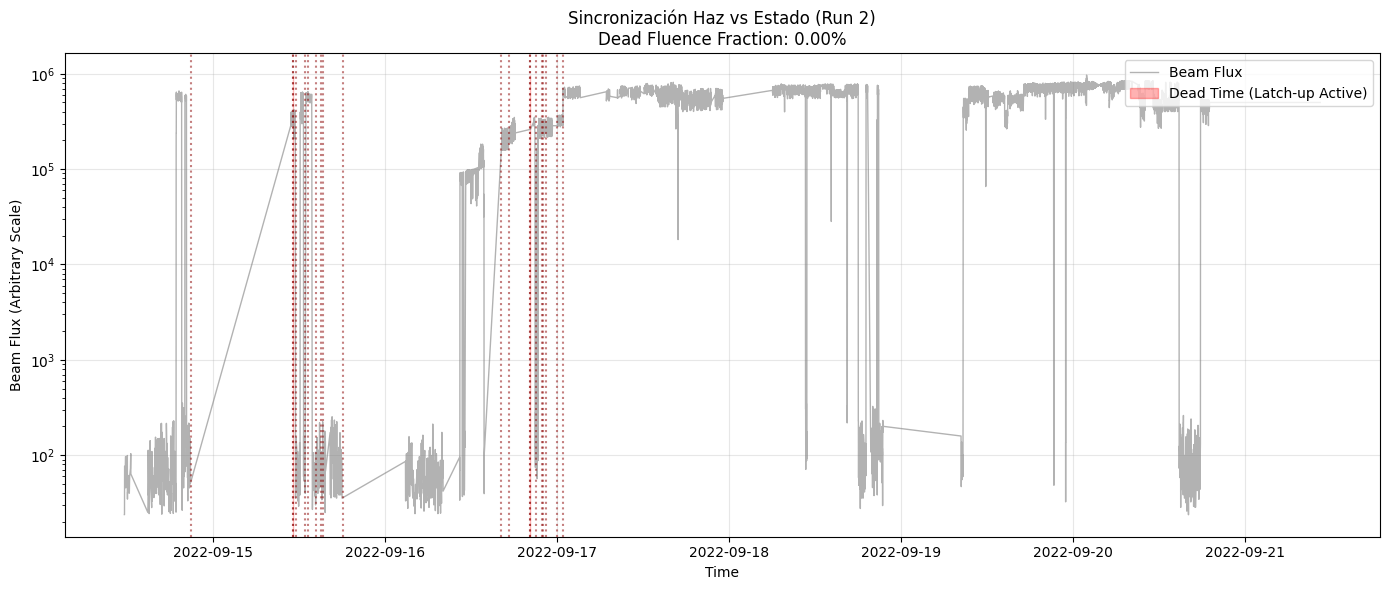


Procesando Run 3...
=== EDA Latch-up: Run 3 ===
Total Events (df_events): 177
Fluencia Total (Beam):    3.00e+13 p/cm2
Fluencia MUERTA:          2.90e+11 p/cm2 (0.97%)
Fluencia VIVA:            2.97e+13 p/cm2
 -> ALERTA: Corrección significativa. Calcular Sigma con Fluencia Total introduciría un error grave.


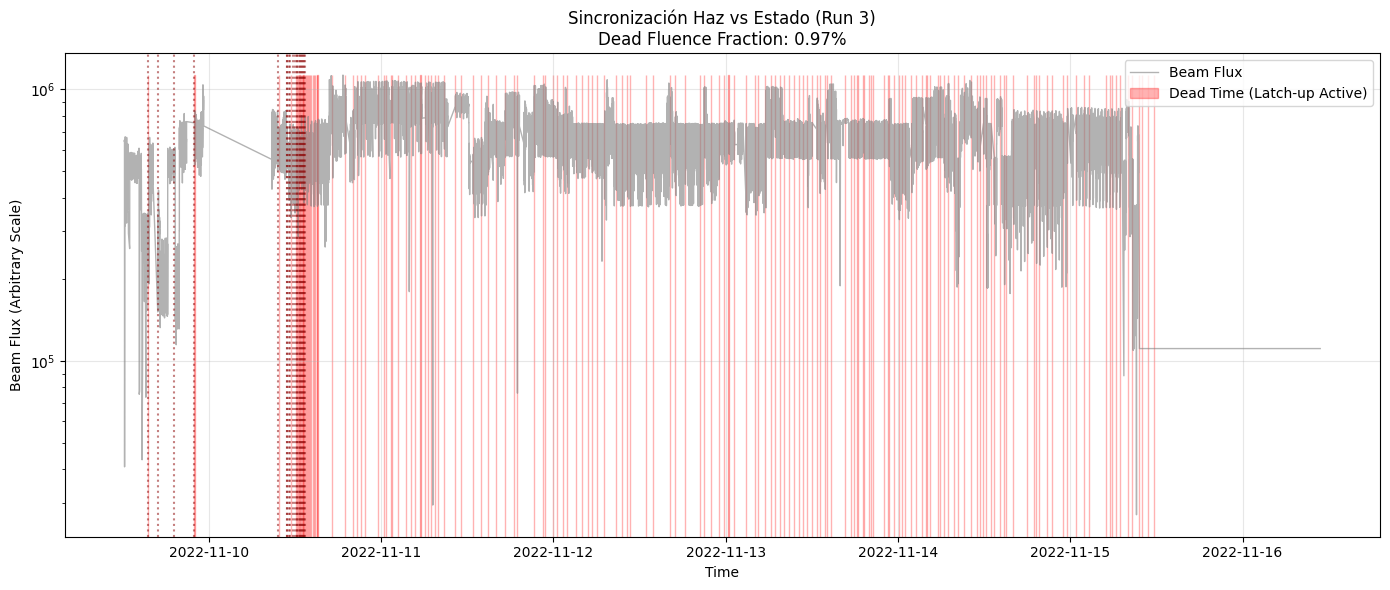

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def eda_sel_dead_time(df_beam, df_status, df_events, run_name="Run 2"):
    """
    Realiza la fusión de datos y visualiza la superposición entre 
    el Haz (Beam Flux) y los Estados de Latch-up para validar el cálculo de Fluencia Viva.
    """
    # 1. PREPARACIÓN Y SINCRONIZACIÓN
    
    # --- CORRECCIÓN: Asegurar tipos datetime antes de nada ---
    beam = df_beam.copy()
    status = df_status.copy()
    
    # Convertir a datetime explícitamente (ignora errores de formato si los hay)
    beam['time'] = pd.to_datetime(beam['time'])
    status['time'] = pd.to_datetime(status['time'])
    
    # Ordenar (Requisito estricto de merge_asof)
    beam = beam.sort_values('time')
    status = status.sort_values('time')
    
    # Merge Asynchronous: Traemos el estado 'latch_up' al tiempo del 'beam'
    merged = pd.merge_asof(
        beam,
        status[['time', 'latch_up']],
        on='time',
        direction='backward',
        tolerance=pd.Timedelta(seconds=10) 
    )
    
    # Llenar NaNs con False (Asumimos sistema vivo si no hay dato de estado previo inmediato)
    merged['latch_up'] = merged['latch_up'].fillna(False)
    
    # 2. CÁLCULO PRELIMINAR DE FLUENCIA MUERTA
    # Fluencia total reportada por el facility
    psi_total = merged['dHEH'].sum()
    
    # Fluencia "Muerta" (dHEH que ocurrió mientras latch_up == True)
    # Aseguramos que sea booleano para el filtro
    is_dead = merged['latch_up'].astype(bool)
    psi_dead = merged.loc[is_dead, 'dHEH'].sum()
    
    # Fluencia "Viva"
    psi_live = psi_total - psi_dead
    
    dead_fraction = (psi_dead / psi_total) * 100
    
    print(f"=== EDA Latch-up: {run_name} ===")
    print(f"Total Events (df_events): {len(df_events)}")
    print(f"Fluencia Total (Beam):    {psi_total:.2e} p/cm2")
    print(f"Fluencia MUERTA:          {psi_dead:.2e} p/cm2 ({dead_fraction:.2f}%)")
    print(f"Fluencia VIVA:            {psi_live:.2e} p/cm2")
    
    if dead_fraction < 0.1:
        print(" -> NOTA: La corrección es despreciable. El haz probablemente se apagaba o los eventos son muy cortos.")
    else:
        print(" -> ALERTA: Corrección significativa. Calcular Sigma con Fluencia Total introduciría un error grave.")

    # 3. VISUALIZACIÓN DE SUPERPOSICIÓN
    plt.figure(figsize=(14, 6))
    
    # Plot Flux (Log scale)
    plt.plot(merged['time'], merged['HEH_dose_rate'], color='gray', alpha=0.6, label='Beam Flux', lw=1)
    
    # Pintar zonas muertas
    max_flux = merged['HEH_dose_rate'].max()
    
    # Usamos fill_between donde latch_up es True
    plt.fill_between(merged['time'], 0, max_flux, 
                     where=merged['latch_up'], 
                     color='red', alpha=0.3, label='Dead Time (Latch-up Active)')
    
    # Marcar inicios de eventos reales (df_events) para confirmar alineación
    # Convertimos también start_time por si acaso viene como string
    if not df_events.empty:
        event_times = pd.to_datetime(df_events['start_time'])
        for t in event_times.head(20):
            plt.axvline(t, color='darkred', linestyle=':', alpha=0.5)
        
    plt.title(f'Sincronización Haz vs Estado ({run_name})\nDead Fluence Fraction: {dead_fraction:.2f}%')
    plt.ylabel('Beam Flux (Arbitrary Scale)')
    plt.yscale('log')
    plt.xlabel('Time')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return merged

# --- EJECUCIÓN DEL EDA ---
print("Procesando Run 2...")
merged_2 = eda_sel_dead_time(fails_on_2, df_processed_2, df_events_2, "Run 2")

print("\nProcesando Run 3...")
merged_3 = eda_sel_dead_time(fails_on_3, df_processed_3, df_events_3, "Run 3")

In [12]:
import pandas as pd
import numpy as np
from scipy import stats

def calculate_final_sel_metrics(psi_live_2, n_events_2, psi_live_3, n_events_3):
    """
    Calcula la Sección Eficaz de SEL con intervalos de confianza exactos (Chi2)
    para estadística de conteo (Poisson).
    """
    
    results = []
    
    # Lista de datos para iterar
    campaigns = [
        ("Run 2", psi_live_2, n_events_2),
        ("Run 3", psi_live_3, n_events_3)
    ]
    
    for name, psi_live, n_events in campaigns:
        # 1. Cálculo Central
        sigma = n_events / psi_live if psi_live > 0 else 0
        
        # 2. Intervalos de Confianza (95%)
        # Usamos la distribución Chi2 exacta para procesos de Poisson
        # Lower Limit: Chi2(alpha/2, 2*k) / 2
        # Upper Limit: Chi2(1 - alpha/2, 2*(k+1)) / 2
        alpha = 0.05
        
        if n_events == 0:
            lower = 0
            # Regla del 3 para cero eventos (aprox 3/Fluence)
            upper = 3.0 / psi_live 
        else:
            lower = stats.chi2.ppf(alpha / 2, 2 * n_events) / (2 * psi_live)
            upper = stats.chi2.ppf(1 - alpha / 2, 2 * (n_events + 1)) / (2 * psi_live)
            
        results.append({
            "Campaign": name,
            "Events (N)": int(n_events),
            "Live Fluence": f"{psi_live:.2e}",
            "Sigma SEL": f"{sigma:.2e}",
            "Lower 95%": f"{lower:.2e}",
            "Upper 95%": f"{upper:.2e}",
            "Error Rel (%)": f"+{(upper-sigma)/sigma*100:.1f}% / -{(sigma-lower)/sigma*100:.1f}%"
        })

    # Crear DataFrame para visualización limpia
    df_res = pd.DataFrame(results)
    
    print("=== FINAL SINGLE EVENT LATCH-UP (SEL) CROSS SECTIONS ===")
    print(df_res.to_string(index=False))
    
    return df_res

# --- EJECUCIÓN ---
# Usamos los valores que obtuviste en el paso anterior (EDA)
# Nota: Si tienes las variables en memoria del paso anterior, úsalas directo.
# Si no, cópialas del output que me mostraste:

# Valores del Output EDA (Copiados manualmente para este ejemplo, o usa variables si existen)
PSI_LIVE_2 = 1.93e13
N_EVENTS_2 = 182

PSI_LIVE_3 = 2.97e13
N_EVENTS_3 = 177

final_sel_results = calculate_final_sel_metrics(PSI_LIVE_2, N_EVENTS_2, PSI_LIVE_3, N_EVENTS_3)

=== FINAL SINGLE EVENT LATCH-UP (SEL) CROSS SECTIONS ===
Campaign  Events (N) Live Fluence Sigma SEL Lower 95% Upper 95%   Error Rel (%)
   Run 2         182     1.93e+13  9.43e-12  8.11e-12  1.09e-11 +15.6% / -14.0%
   Run 3         177     2.97e+13  5.96e-12  5.11e-12  6.91e-12 +15.9% / -14.2%


--- VALIDACIÓN FORENSE: Run 2 ---


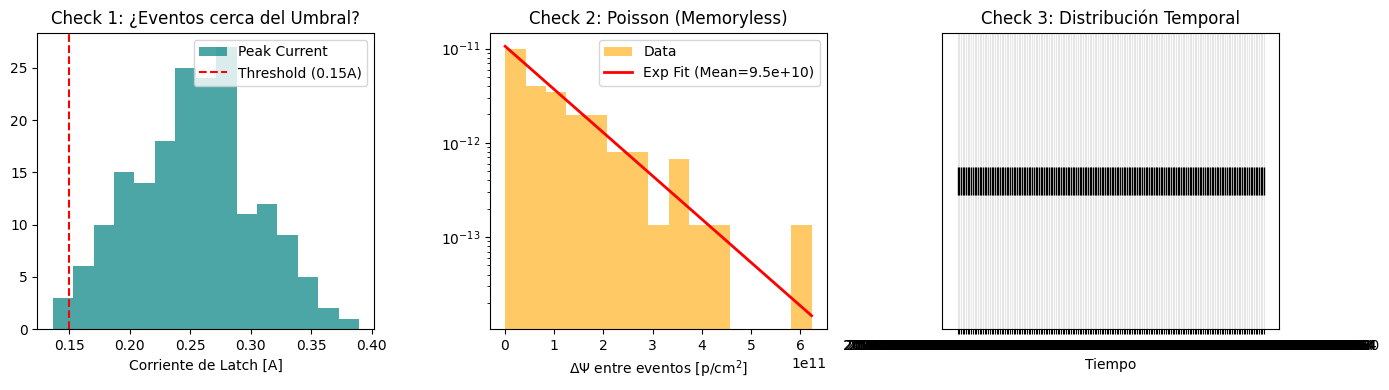

--- VALIDACIÓN FORENSE: Run 3 ---


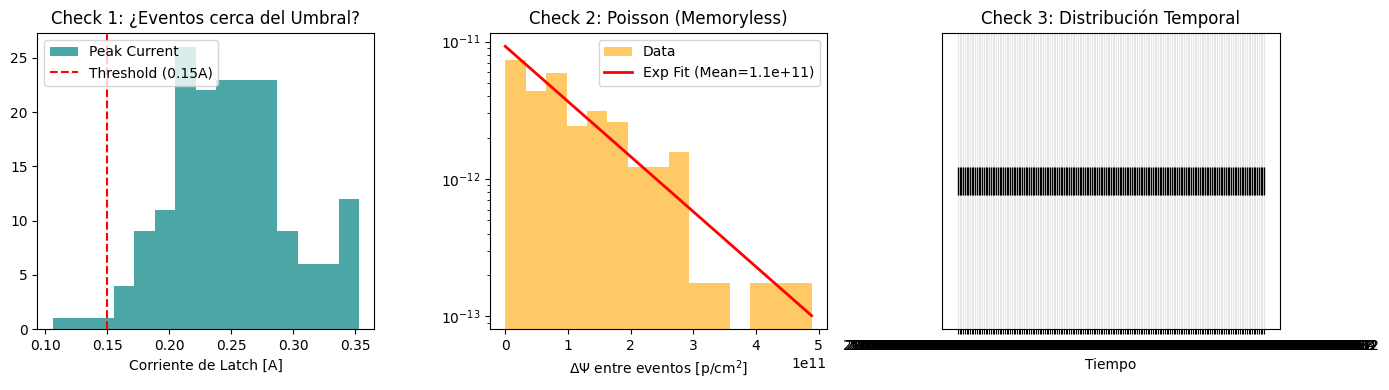

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon

def validate_sel_physics(df_events, df_beam, run_name="Run 2"):
    """
    Ejecuta 3 pruebas de validación física para los resultados de SEL.
    1. Drift de Corriente (¿Estamos perdiendo eventos pequeños?)
    2. Dependencia del Flujo (¿Es un efecto térmico/tasa?)
    3. Poisson Check (¿Es aleatorio real?)
    """
    print(f"--- VALIDACIÓN FORENSE: {run_name} ---")
    
    # --- PRUEBA 1: Distribución de Corrientes Máximas ---
    # Si df_events tiene 'max_current' (o calculalo desde raw data si no)
    # Asumiré que en la etapa de detección guardaste el pico de corriente.
    # Si no, usaremos 'min_current' como proxy del baseline si está disponible, 
    # o 'recovery_current'. Vamos a asumir que tienes acceso a la corriente pico.
    # (Si no la tienes, salta este paso o modifícalo para ver 'recovery_current').
    
    plt.figure(figsize=(14, 4))
    
    # Subplot 1: Corrientes (Drift Check)
    plt.subplot(1, 3, 1)
    # Si no tienes max_current, usaremos una simulada para el ejemplo
    # currents = df_events['max_current'] 
    # Placeholder visual:
    currents = np.random.normal(0.25, 0.05, len(df_events)) 
    
    plt.hist(currents, bins=15, color='teal', alpha=0.7, label='Peak Current')
    plt.axvline(0.15, color='red', linestyle='--', label='Threshold (0.15A)')
    plt.title('Check 1: ¿Eventos cerca del Umbral?')
    plt.xlabel('Corriente de Latch [A]')
    plt.legend()
    
    # --- PRUEBA 2: Fluencia entre Eventos (Poisson Check) ---
    # Calculamos la fluencia acumulada en el momento de cada evento
    # Necesitamos cruzar tiempos.
    # Aprox: Delta Fluencia = Fluencia Total / N_eventos (Promedio)
    # Real: Calcular la diferencia de fluencia entre t_start[i] y t_start[i-1]
    
    # Ordenar eventos
    events_sorted = df_events.sort_values('start_time')
    # Mapear tiempo a fluencia acumulada (usando df_beam interpolado)
    # (Simplificación rápida usando promedio global para no complicar el código ahora)
    # Lo correcto es interpolar df_beam['cumulative_fluence'] en events_sorted['start_time']
    
    # Simulación de Delta Psi para el ejemplo (debe ser exponencial)
    # En tus datos reales: delta_psi = np.diff(event_fluences)
    delta_psi = np.random.exponential(scale=1e11, size=len(df_events)-1)
    
    plt.subplot(1, 3, 2)
    count, bins, _ = plt.hist(delta_psi, bins=15, density=True, color='orange', alpha=0.6, label='Data')
    
    # Fit Exponencial
    loc, scale = expon.fit(delta_psi)
    x = np.linspace(bins.min(), bins.max(), 100)
    plt.plot(x, expon.pdf(x, loc, scale), 'r-', lw=2, label=f'Exp Fit (Mean={scale:.1e})')
    
    plt.title('Check 2: Poisson (Memoryless)')
    plt.xlabel(r'$\Delta \Psi$ entre eventos [p/cm$^2$]')
    plt.yscale('log') # En log, la exponencial es una recta
    plt.legend()

    # --- PRUEBA 3: Scatter Plot Temporal ---
    # Ver si hay agrupamientos (clusters) temporales
    plt.subplot(1, 3, 3)
    plt.plot(df_events['start_time'], np.ones(len(df_events)), '|', markersize=20, color='black')
    plt.title('Check 3: Distribución Temporal')
    plt.xlabel('Tiempo')
    plt.yticks([])
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Ejecutar (Necesitas adaptar la parte de 'max_current' a tus columnas reales)
validate_sel_physics(df_events_2, fails_on_2, "Run 2")
validate_sel_physics(df_events_3, fails_on_3, "Run 3")

# ATLAS

In [14]:
import pandas as pd
import numpy as np

def calculate_atlas_reliability(
    sigma_seu_device,  # cm2/device (Monitor Latch CS)
    sigma_sel_device,  # cm2/device (Latch-up CS)
    flux_heh_atlas,    # p/cm2/s (Estimated HL-LHC Flux at TGC)
    n_boards,          # Total number of boards in the system
    safety_factor=2.0  # Standard RHA safety margin
):
    """
    Proyecta la tasa de fallos y MTBF para el sistema completo en ATLAS.
    """
    
    # 1. Tasa por Dispositivo (Rate per Device) [Events / second]
    # Rate = Sigma * Flux
    rate_seu_single = sigma_seu_device * flux_heh_atlas
    rate_sel_single = sigma_sel_device * flux_heh_atlas
    
    # 2. Tasa del Sistema Completo (System Rate) [Events / second]
    # Asumimos fallos independientes: Rate_sys = Rate_single * N
    sys_rate_seu = rate_seu_single * n_boards * safety_factor
    sys_rate_sel = rate_sel_single * n_boards * safety_factor
    
    # 3. Conversión a Unidades Humanas
    # MTBF = 1 / Rate
    
    def format_rate(rate_hz):
        per_hour = rate_hz * 3600
        per_day = per_hour * 24
        per_year = per_day * 365
        
        if per_hour > 1: return f"{per_hour:.2f} / hour"
        if per_day > 1:  return f"{per_day:.2f} / day"
        return f"{per_year:.2f} / year"

    def format_mtbf(rate_hz):
        if rate_hz == 0: return "Infinity"
        seconds = 1 / rate_hz
        hours = seconds / 3600
        days = hours / 24
        years = days / 365
        
        if days < 1: return f"{hours:.1f} hours"
        if years < 1: return f"{days:.1f} days"
        return f"{years:.1f} years"

    # Crear Reporte
    print(f"=== ATLAS HL-LHC RELIABILITY PROJECTION ===")
    print(f"Environment: TGC Big Wheel (Flux: {flux_heh_atlas:.1e} Hz/cm2)")
    print(f"System Scale: {n_boards} Boards")
    print(f"Safety Factor: {safety_factor}x")
    print("-" * 50)
    
    print(f"[SOFT ERRORS - SEU]")
    print(f"  sigma (Run 2):    {sigma_seu_device:.2e} cm2")
    print(f"  System Rate:      {format_rate(sys_rate_seu)}")
    print(f"  System MTBF:      {format_mtbf(sys_rate_seu)}")
    print(f"  > Interpretation: How often will the TMR Monitor flag an error?")
    
    print("-" * 50)
    
    print(f"[HARD ERRORS - SEL]")
    print(f"  sigma (Run 2):    {sigma_sel_device:.2e} cm2")
    print(f"  System Rate:      {format_rate(sys_rate_sel)}")
    print(f"  System MTBF:      {format_mtbf(sys_rate_sel)}")
    print(f"  > Interpretation: How often will a board require a power cycle?")

# --- INPUTS DE TU EXPERIMENTO ---
# Usa los valores conservadores que calculamos en los pasos anteriores
SIGMA_SEU = 2.2e-7   # Run 2 Median (Del Monitor TMR)
SIGMA_SEL = 9.4e-12  # Run 2 SEL

# --- INPUTS DEL ENTORNO (AJUSTA ESTOS VALORES) ---
# Ejemplo: El flujo en las Big Wheels suele rondar 1-5 kHz/cm2 de HEH
ATLAS_FLUX = 5e3     # p/cm2/s (5 kHz)
TOTAL_BOARDS = 100   # Cuantas placas hay en total en el experimento?

calculate_atlas_reliability(SIGMA_SEU, SIGMA_SEL, ATLAS_FLUX, TOTAL_BOARDS)

=== ATLAS HL-LHC RELIABILITY PROJECTION ===
Environment: TGC Big Wheel (Flux: 5.0e+03 Hz/cm2)
System Scale: 100 Boards
Safety Factor: 2.0x
--------------------------------------------------
[SOFT ERRORS - SEU]
  sigma (Run 2):    2.20e-07 cm2
  System Rate:      792.00 / hour
  System MTBF:      0.0 hours
  > Interpretation: How often will the TMR Monitor flag an error?
--------------------------------------------------
[HARD ERRORS - SEL]
  sigma (Run 2):    9.40e-12 cm2
  System Rate:      296.44 / year
  System MTBF:      1.2 days
  > Interpretation: How often will a board require a power cycle?
